<a href="https://www.kaggle.com/awsaf49/sartorius-mmdetection-train?scriptVersionId=83980787" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# [Sartorius - Cell Instance Segmentation](https://www.kaggle.com/c/petfinder-pawpularity-score)
> Detect single neuronal cells in microscopy images

![](https://storage.googleapis.com/kaggle-competitions/kaggle/30201/logos/header.png?t=2021-09-03-15-27-46)

# Notebooks:
* Train: [Sartorius: MMDetection [Train]](https://www.kaggle.com/awsaf49/sartorius-mmdetection-train)
* Infer: [Sartorius: MMDetection [Infer]](https://www.kaggle.com/awsaf49/sartorius-mmdetection-infer)

# Please Upvote If you find this notebook Useful :)

# Install Libraries


In [1]:
# dependencies
!pip install -q /kaggle/input/mmdet-lib-ds-v2/torch-1.7.0%2Bcu110-cp37-cp37m-linux_x86_64.whl
!pip install -q /kaggle/input/mmdet-lib-ds-v2/torchvision-0.8.0-cp37-cp37m-manylinux1_x86_64.whl
!pip install -q /kaggle/input/mmdet-lib-ds-v2/yapf-0.32.0-py2.py3-none-any.whl
!pip install -q /kaggle/input/mmdet-lib-ds-v2/pycocotools-2.0.3/pycocotools-2.0.3.tar
!pip install -q /kaggle/input/mmdet-lib-ds-v2/mmcv_full-1.4.2-cp37-cp37m-manylinux1_x86_64.whl
!pip install -q /kaggle/input/mmdet-lib-ds-v2/addict-2.4.0-py3-none-any.whl


#wandb
!pip install -qU wandb

# Import Libraries

In [26]:
from itertools import groupby
from pycocotools import mask as mutils
from pycocotools.coco import COCO
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import wandb
from PIL import Image
import gc

# WandB

In [3]:
wandb.login(anonymous='must')

wandb: Currently logged in as: anony-mouse-178891 (use `wandb login --relogin` to force relogin)


True

# Meta Data

In [4]:
ROOT = '../input/sartorius-cell-instance-segmentation'
DATA_DIR = '../input/sartorius-coco-dataset'    

# Train Data
df = pd.read_csv(f'{ROOT}/train.csv')
df['image_path'] = ROOT + '/train/' + df['id'] + '.png'
tmp_df = df.drop_duplicates(subset=["id", "image_path"]).reset_index(drop=True)
tmp_df["annotation"] = df.groupby("id")["annotation"].agg(list).reset_index(drop=True)
df = tmp_df.copy()
df['label']   = df.cell_type.map({v:k for k, v in enumerate(df.cell_type.unique())})
df['num_ins'] = df.annotation.map(lambda x: len(x))
display(df.head(2))

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta,image_path,label
0,0030fd0e6378,[118145 6 118849 7 119553 8 120257 8 120961 9 ...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00,../input/sartorius-cell-instance-segmentation/...,0
1,0140b3c8f445,[32499 3 33201 7 33902 9 34604 10 35306 11 360...,704,520,astro,09h00m00s,2020-09-13,astros[cereb]_F8-3_Vessel-361_Ph_4,0 days 09:00:00,../input/sartorius-cell-instance-segmentation/...,1


# Visualization


loading annotations into memory...
Done (t=0.71s)
creating index...
index created!


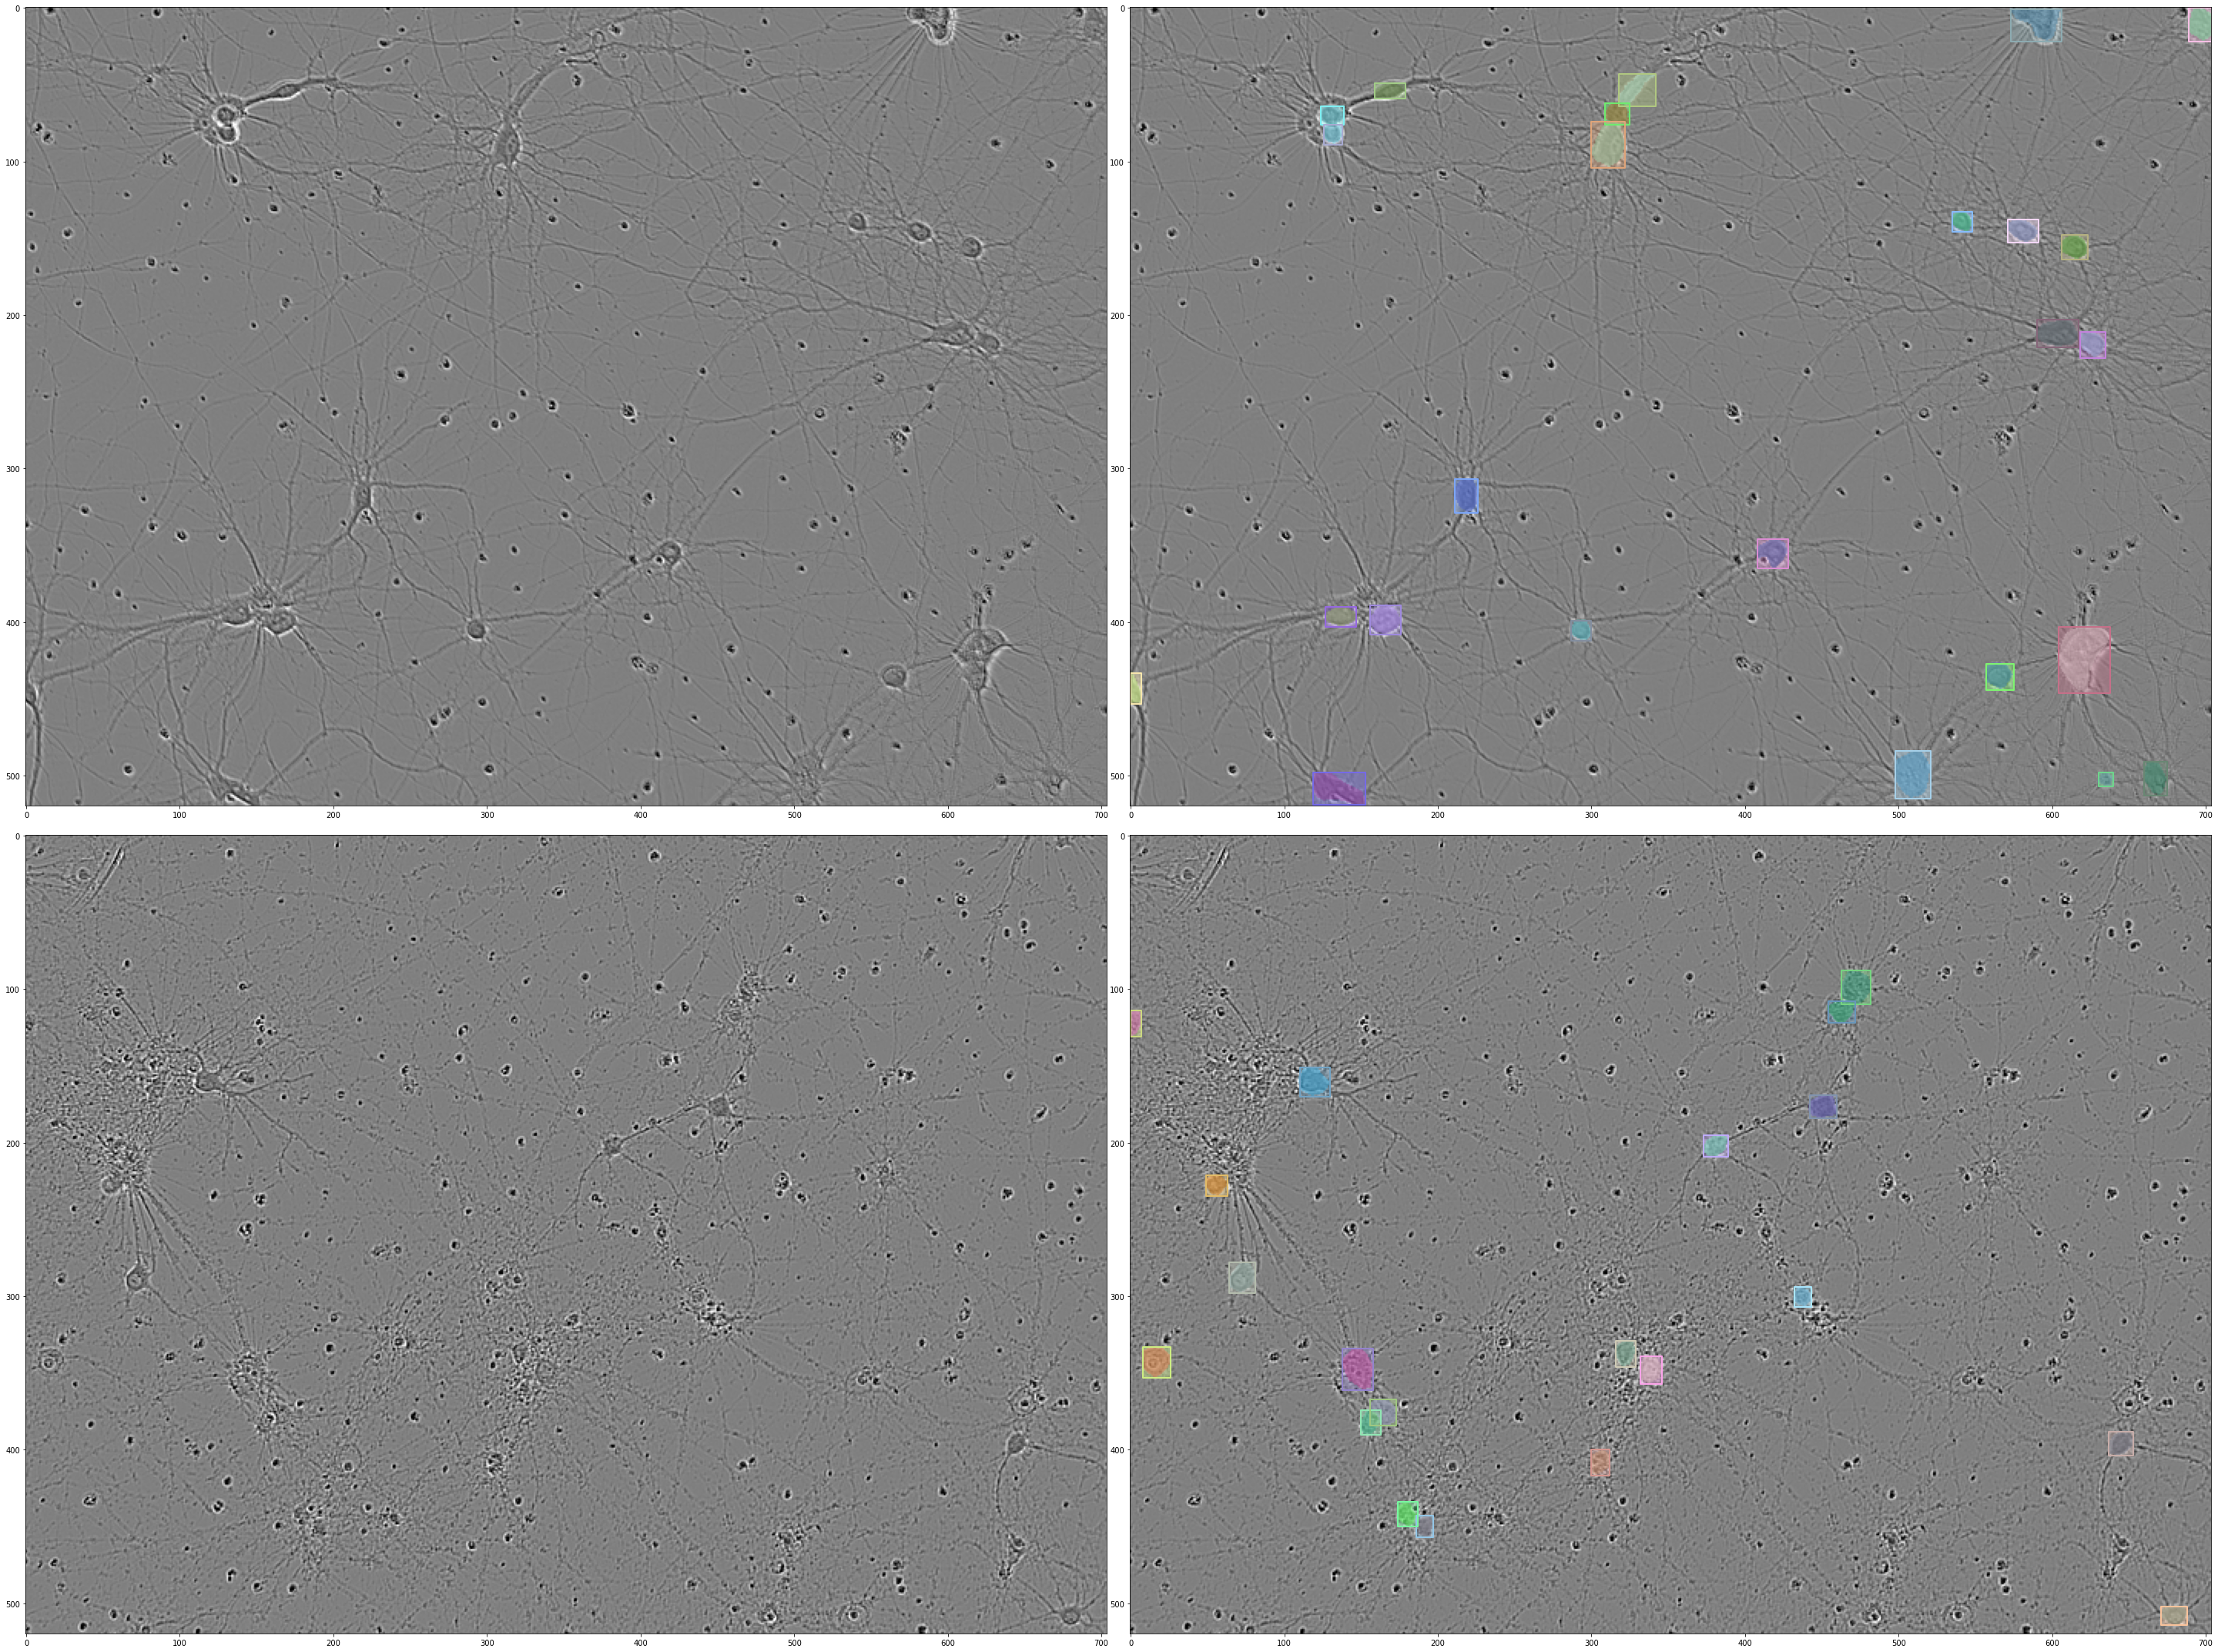

In [28]:
annFile = f'{DATA_DIR}/annotations_train.json'
coco    = COCO(annFile)
imgIds  = coco.getImgIds()

tmp_df = df.query("num_ins<=30 and num_ins>=15").head(2)
_,axs = plt.subplots(len(tmp_df),2,figsize=(40,15 * len(tmp_df)))
for (_, row), ax in zip(tmp_df.iterrows(), axs):
    img = cv2.imread(DATA_DIR+f'/train2017/{row.id}.png')
    img_img = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8)).apply(img[...,0])
    annIds  = coco.getAnnIds(imgIds=[row.id])
    anns    = coco.loadAnns(annIds)
    ax[0].imshow(img)
    ax[1].imshow(img)
    plt.sca(ax[1])
    coco.showAnns(anns, draw_bbox=True)
plt.tight_layout()
plt.show()
del coco; gc.collect()

# MMDet

In [30]:
# mmdet
!rm -r /kaggle/working/mmdetection
!cp -r /kaggle/input/mmdet-repo-ds /kaggle/working/mmdetection
%cd mmdetection
!pip install -q -e .

/kaggle/working/mmdetection


# Custom Config
> You can tune the parameters using following cells. 

In [31]:
!mkdir -p configs/sartorius

# Config: `Base Model`
* **Num Classes** 
* **Score-Theshold**
* **IoU**
* **Wandb**
```
dict(type='WandbLoggerHook',
     init_kwargs=dict(project='sartorius',
                      name=f'model-mask_rcnn_r50_fpn_1x_coco',
                      entity=None))
```

In [35]:
%%writefile configs/sartorius/custom_config.py

# model settings
model = dict(
    type='MaskRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[.0, .0, .0, .0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        loss_bbox=dict(type='L1Loss', loss_weight=1.0)),
    roi_head=dict(
        type='StandardRoIHead',
        bbox_roi_extractor=dict(
            type='SingleRoIExtractor',
            roi_layer=dict(type='RoIAlign', output_size=7, sampling_ratio=0),
            out_channels=256,
            featmap_strides=[4, 8, 16, 32]),
        bbox_head=dict(
            type='Shared2FCBBoxHead',
            in_channels=256,
            fc_out_channels=1024,
            roi_feat_size=7,
            num_classes=3,
            bbox_coder=dict(
                type='DeltaXYWHBBoxCoder',
                target_means=[0., 0., 0., 0.],
                target_stds=[0.1, 0.1, 0.2, 0.2]),
            reg_class_agnostic=False,
            loss_cls=dict(
                type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0),
            loss_bbox=dict(type='L1Loss', loss_weight=1.0)),
        mask_roi_extractor=dict(
            type='SingleRoIExtractor',
            roi_layer=dict(type='RoIAlign', output_size=14, sampling_ratio=0),
            out_channels=256,
            featmap_strides=[4, 8, 16, 32]),
        mask_head=dict(
            type='FCNMaskHead',
            num_convs=4,
            in_channels=256,
            conv_out_channels=256,
            num_classes=3,
            loss_mask=dict(
                type='CrossEntropyLoss', use_mask=True, loss_weight=1.0))),
    # model training and testing settings
    train_cfg=dict(
        rpn=dict(
            assigner=dict(
                type='MaxIoUAssigner',
                pos_iou_thr=0.7,
                neg_iou_thr=0.3,
                min_pos_iou=0.3,
                match_low_quality=True,
                ignore_iof_thr=-1),
            sampler=dict(
                type='RandomSampler',
                num=256,
                pos_fraction=0.5,
                neg_pos_ub=-1,
                add_gt_as_proposals=False),
            allowed_border=-1,
            pos_weight=-1,
            debug=False),
        rpn_proposal=dict(
            nms_pre=2000,
            max_per_img=1000,
            nms=dict(type='nms', iou_threshold=0.7),
            min_bbox_size=0),
        rcnn=dict(
            assigner=dict(
                type='MaxIoUAssigner',
                pos_iou_thr=0.5,
                neg_iou_thr=0.5,
                min_pos_iou=0.5,
                match_low_quality=True,
                ignore_iof_thr=-1),
            sampler=dict(
                type='RandomSampler',
                num=512,
                pos_fraction=0.25,
                neg_pos_ub=-1,
                add_gt_as_proposals=True),
            mask_size=28,
            pos_weight=-1,
            debug=False)),
    test_cfg=dict(
        rpn=dict(
            nms_pre=1000,
            max_per_img=1000,
            nms=dict(type='nms', iou_threshold=0.7),
            min_bbox_size=0),
        rcnn=dict(
            score_thr=0.05,
            nms=dict(type='nms', iou_threshold=0.5),
            max_per_img=100,
            mask_thr_binary=0.5)))

# dataset settings
dataset_type = 'CocoDataset'
classes = ('shsy5y','astro','cort',) # Added
data_root = '/kaggle/input/sartorius-coco-dataset/' # Modified
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True, with_mask=True),
    dict(type='Resize', img_scale=(1333, 800), keep_ratio=True),
    dict(type='RandomFlip', direction=['horizontal', 'vertical'], flip_ratio=0.5), # augmentation starts
    dict(type='PhotoMetricDistortion',
         brightness_delta=32, contrast_range=(0.5, 1.5),
         saturation_range=(0.5, 1.5), hue_delta=18),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels', 'gt_masks']),
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1333, 800),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
#             dict(type='RandomFlip'),
            dict(type='Normalize', **img_norm_cfg),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]
data = dict(
    samples_per_gpu=6, # BATCH_SIZE
    workers_per_gpu=2,
    train=dict(
        type=dataset_type,
        ann_file=data_root + 'annotations_train.json', # Modified
        img_prefix=data_root + 'train2017/', # Modified
        classes=classes, # Added
        pipeline=train_pipeline),
    val=dict(
        type=dataset_type,
        ann_file=data_root + 'annotations_valid.json', # Modified
        img_prefix=data_root + 'valid2017/', # Modified
        classes=classes, # Added
        pipeline=test_pipeline),
    test=dict(
        type=dataset_type,
        ann_file=data_root + 'annotations_valid.json', # Modified
        img_prefix=data_root + 'valid2017/', # Modified
        classes=classes, # Added
        pipeline=test_pipeline))
evaluation = dict(interval=1,
                  metric=['segm'], # bbox, segm
                  save_best='segm_mAP')



# optimizer
optimizer = dict(type='SGD', lr=0.025, momentum=0.9, weight_decay=0.0001)
optimizer_config = dict(grad_clip=None)
# learning policy
lr_config = dict(
    policy='step',
    warmup='linear',
    warmup_iters=500,
    warmup_ratio=0.001,
    step=[8, 11])
runner = dict(type='EpochBasedRunner', max_epochs=20)

# default_runtime
checkpoint_config = dict(interval=1)
# yapf:disable
log_config = dict(
    interval=50,
    hooks=[
        dict(type='TextLoggerHook'),
        dict(type='WandbLoggerHook', # wandb logger
             init_kwargs=dict(project='sartorius',
                              name=f'model-mask_rcnn_r50_fpn_1x_coco',
                              entity=None))
        # dict(type='TensorboardLoggerHook')
    ])
# yapf:enable
custom_hooks = [dict(type='NumClassCheckHook')]

dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = 'https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_fpn_1x_coco/mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth'
resume_from = None
workflow = [('train', 1)]

Overwriting configs/sartorius/custom_config.py


# Config: `Model` & `Augmentation`
* **Augmentation** 
    * **Flip**
    * **Multi-Scale**
    * **PhotoMetricDistortion**
* **Batch Size**
* **IoU**

# Config: `scheduler_1x.py`
* **Epochs**
* **Learning Rate**
* **Optimizer**

# Training

In [ ]:
!python tools/train.py configs/sartorius/custom_config.py

fatal: not a git repository (or any parent up to mount point /kaggle)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
2021-12-30 22:14:50,907 - mmdet - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) [GCC 9.4.0]
CUDA available: True
GPU 0: Tesla P100-PCIE-16GB
CUDA_HOME: /usr/local/cuda
NVCC: Build cuda_11.0_bu.TC445_37.28845127_0
GCC: gcc (Ubuntu 9.3.0-17ubuntu1~20.04) 9.3.0
PyTorch: 1.7.0+cu110
PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v1.6.0 (Git Hash 5ef631a030a6f73131c77892041042805a06064f)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.0
  - NVCC architecture flags: -gencode;arch=compu

In [ ]:
!ls -Rl .

# Reference
* [mmdetection for segmentation [training]](https://www.kaggle.com/its7171/mmdetection-for-segmentation-training) by @its7171
* [Sartorius Segmentation - Mask Dataset](https://www.kaggle.com/dschettler8845/sartorius-segmentation-mask-dataset) by @dschettler8845

# Please Upvote If you find this notebook Useful :)